In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

df_production = pd.read_csv("production.csv")
df_weather = pd.read_csv("weather_info.csv")
df_weather = df_weather[df_weather["date"] <= "2024-05-26"]

df_weather = df_weather.sort_values(by=["date", "hour", "lat", "lon"], ascending=[True, True, True, True])

# Check for missing values
missing_values = df_weather.isnull().sum()

# replace NaN
def mean_replace_nan(feature):
    arr = df_weather[feature].values
    new_arr = []
    length = len(arr)
    for idx, val in enumerate(arr):
        if pd.isna(val):
            # cover edge cases
            if idx - 25 < 0:
                # value for the same lat and lon 1 hour after
                new_arr.append(arr[idx + 25])
            elif idx + 25 > length - 1:
                # value for the same lat and lon 1 hour ago
                new_arr.append(arr[idx - 25])
            else:
                # take the mean
                new_arr.append((arr[idx - 25] + arr[idx + 25]) / 2)
        else:
            new_arr.append(val)
    return new_arr

# get the features that contain NaN
features_with_missing_values = [col for col in df_weather.columns if df_weather[col].isnull().any()]
# use above function to replace NaN with mean values
for feature in features_with_missing_values:
    new_arr = mean_replace_nan(feature)
    df_weather[feature] = new_arr

df_weather = df_weather[(df_weather["date"] <= "2024-05-26") & (df_weather["date"] > "2022-01-01")]
df_production = df_production[df_production["date"] > "2022-01-01"]

# removing duplicate values
df_production = df_production.drop_duplicates(subset=["date", "hour"])

# selecting the closest location for forecasts
df_weather_arima = df_weather[(df_weather["lat"] == 38.25) & (df_weather["lon"] == 35)]
df_merged = pd.merge(df_weather_arima, df_production, on=["date", "hour"])


columns_to_standardize = ['dswrf_surface', 'tcdc_low.cloud.layer', 'tcdc_middle.cloud.layer',
                          'tcdc_entire.atmosphere', 'uswrf_top_of_atmosphere',
                          'csnow_surface', 'dlwrf_surface', 'uswrf_surface', 'tmp_surface']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns

df_merged[columns_to_standardize] = scaler.fit_transform(df_merged[columns_to_standardize])

# Dropping the unnecessary lat and lon features
df_merged.drop(columns=["lat", "lon"], inplace=True)
df_merged['datetime'] = pd.to_datetime(df_merged['date'] + ' ' + df_merged['hour'].astype(str) + ':00:00')
binary_month = pd.get_dummies(df_merged.datetime.dt.month, prefix='month').astype(int)
df_merged = pd.concat([df_merged, binary_month], axis=1)
#df_merged = pd.concat([df_merged, binary_hour], axis=1)
df_merged.drop(columns=["tcdc_high.cloud.layer"], inplace=True)

df_merged

,date,hour,dswrf_surface,tcdc_low.cloud.layer,tcdc_middle.cloud.layer,tcdc_entire.atmosphere,uswrf_top_of_atmosphere,csnow_surface,dlwrf_surface,uswrf_surface,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2022-01-02,0,-0.798497,2.085578,2.063201,1.273121,-0.835520,-0.188175,-0.109158,-0.757090,...,0,0,0,0,0,0,0,0,0,0
1,2022-01-02,1,-0.798497,2.121407,2.063201,1.273121,-0.835520,-0.188175,-0.090943,-0.757090,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-02,2,-0.798497,2.172165,2.063201,1.273121,-0.835520,-0.188175,0.022903,-0.757090,...,0,0,0,0,0,0,0,0,0,0
3,2022-01-02,3,-0.798497,2.205008,2.063201,1.273121,-0.835520,-0.188175,0.134061,-0.757090,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-02,4,-0.798497,2.375196,1.841549,1.273121,-0.835520,5.314190,0.768226,-0.757090,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21019,2024-05-26,19,0.527159,0.315025,0.629303,0.755785,1.131216,-0.188175,1.160264,0.386232,...,0,0,1,0,0,0,0,0,0,0
21020,2024-05-26,20,0.266872,0.727059,0.916630,0.859252,0.827762,-0.188175,1.284720,0.161586,...,0,0,1,0,0,0,0,0,0,0
21021,2024-05-26,21,0.089330,1.001749,1.108181,0.929798,0.550548,-0.188175,1.348837,0.008353,...,0,0,1,0,0,0,0,0,0,0
21022,2024-05-26,22,-0.798497,2.369225,2.060465,1.270769,-0.835520,-0.188175,1.266869,-0.757090,...,0,0,1,0,0,0,0,0,0,0


In [91]:
def flatten_forecast(forecasts):
    flattened_forecasts = []
    length = len(forecasts)
    days = len(forecasts[0])
    for i in range(days):
        # hours 0, 1, 2, 3, 4
        initial_list = [0, 0, 0, 0, 0]
        for j in range(length):
            initial_list.append(forecasts[j][i])
        # hours 22 and 23
        initial_list.extend([0, 0])
        flattened_forecasts.extend(initial_list)
    return flattened_forecasts

def get_data(hour, start, end):
    df_hour = df_merged[df_merged["hour"] == hour]
    df_hour['date'] = pd.to_datetime(df_hour['date'])
    df_hour.reset_index(drop=True, inplace=True)
    df_test = df_hour[(df_hour["date"] >= start) & (df_hour["date"] <= end)]
    df_train = df_hour[df_hour["date"] < start]  
    y_date_train = df_train.date
    y_date_test = df_test.date
    y_train = np.array(df_train.production)
    y_test = np.array(df_test.production)
    df_train.drop(columns=['date', 'hour', 'production', 'datetime'], inplace=True)
    df_test.drop(columns=['date', 'hour', 'production', 'datetime'], inplace=True)
    return df_train, df_test, y_train, y_test

def forecast_5_days(start_date, end_date, arima_order, hour):
    current_start = start_date
    forecasts = []

    while current_start < end_date:
        current_end = current_start + timedelta(days=4)
        df_train, df_test, y_train, y_test = get_data(hour, current_start, current_end)
        forecast_steps = len(list(y_test))
        arima = ARIMA(y_train, exog=df_train.values, order=arima_order)
        res = arima.fit()
        forecast = res.forecast(steps=forecast_steps, exog=df_test.values)
        forecast = np.clip(forecast, 0, 10)
        forecasts.extend(list(forecast))      
        current_start = current_end + timedelta(days=1)

    return forecasts

In [92]:
arima_mapping = {
    5: (2,1,2),
    6: (2,1,2),
    7: (2,1,2),
    8: (0,1,2),
    9: (2,1,2),
    10: (2,1,1),
    11: (0,1,1),
    12: (2,1,0),
    13: (0,1,0),
    14: (1,1,0),
    15: (0,1,1),
    16: (2,1,0),
    17: (0,1,2),
    18: (0,1,2),
    19: (0,1,2),
    20: (0,1,2),
    21: (0,1,2)
}

start_date = pd.to_datetime('2023-02-01')
end_date = pd.to_datetime('2023-05-15')
forecast_list = []

for hour in range(5, 22):
    arima_order = arima_mapping[hour]
    print(f"HOUR {hour}")
    hourly_forecasts = forecast_5_days(start_date, end_date, arima_order, hour)
    forecast_list.append(hourly_forecasts)

HOUR 5
HOUR 6
HOUR 7
HOUR 8
HOUR 9
HOUR 10
HOUR 11
HOUR 12
HOUR 13
HOUR 14
HOUR 15
HOUR 16
HOUR 17
HOUR 18
HOUR 19
HOUR 20
HOUR 21


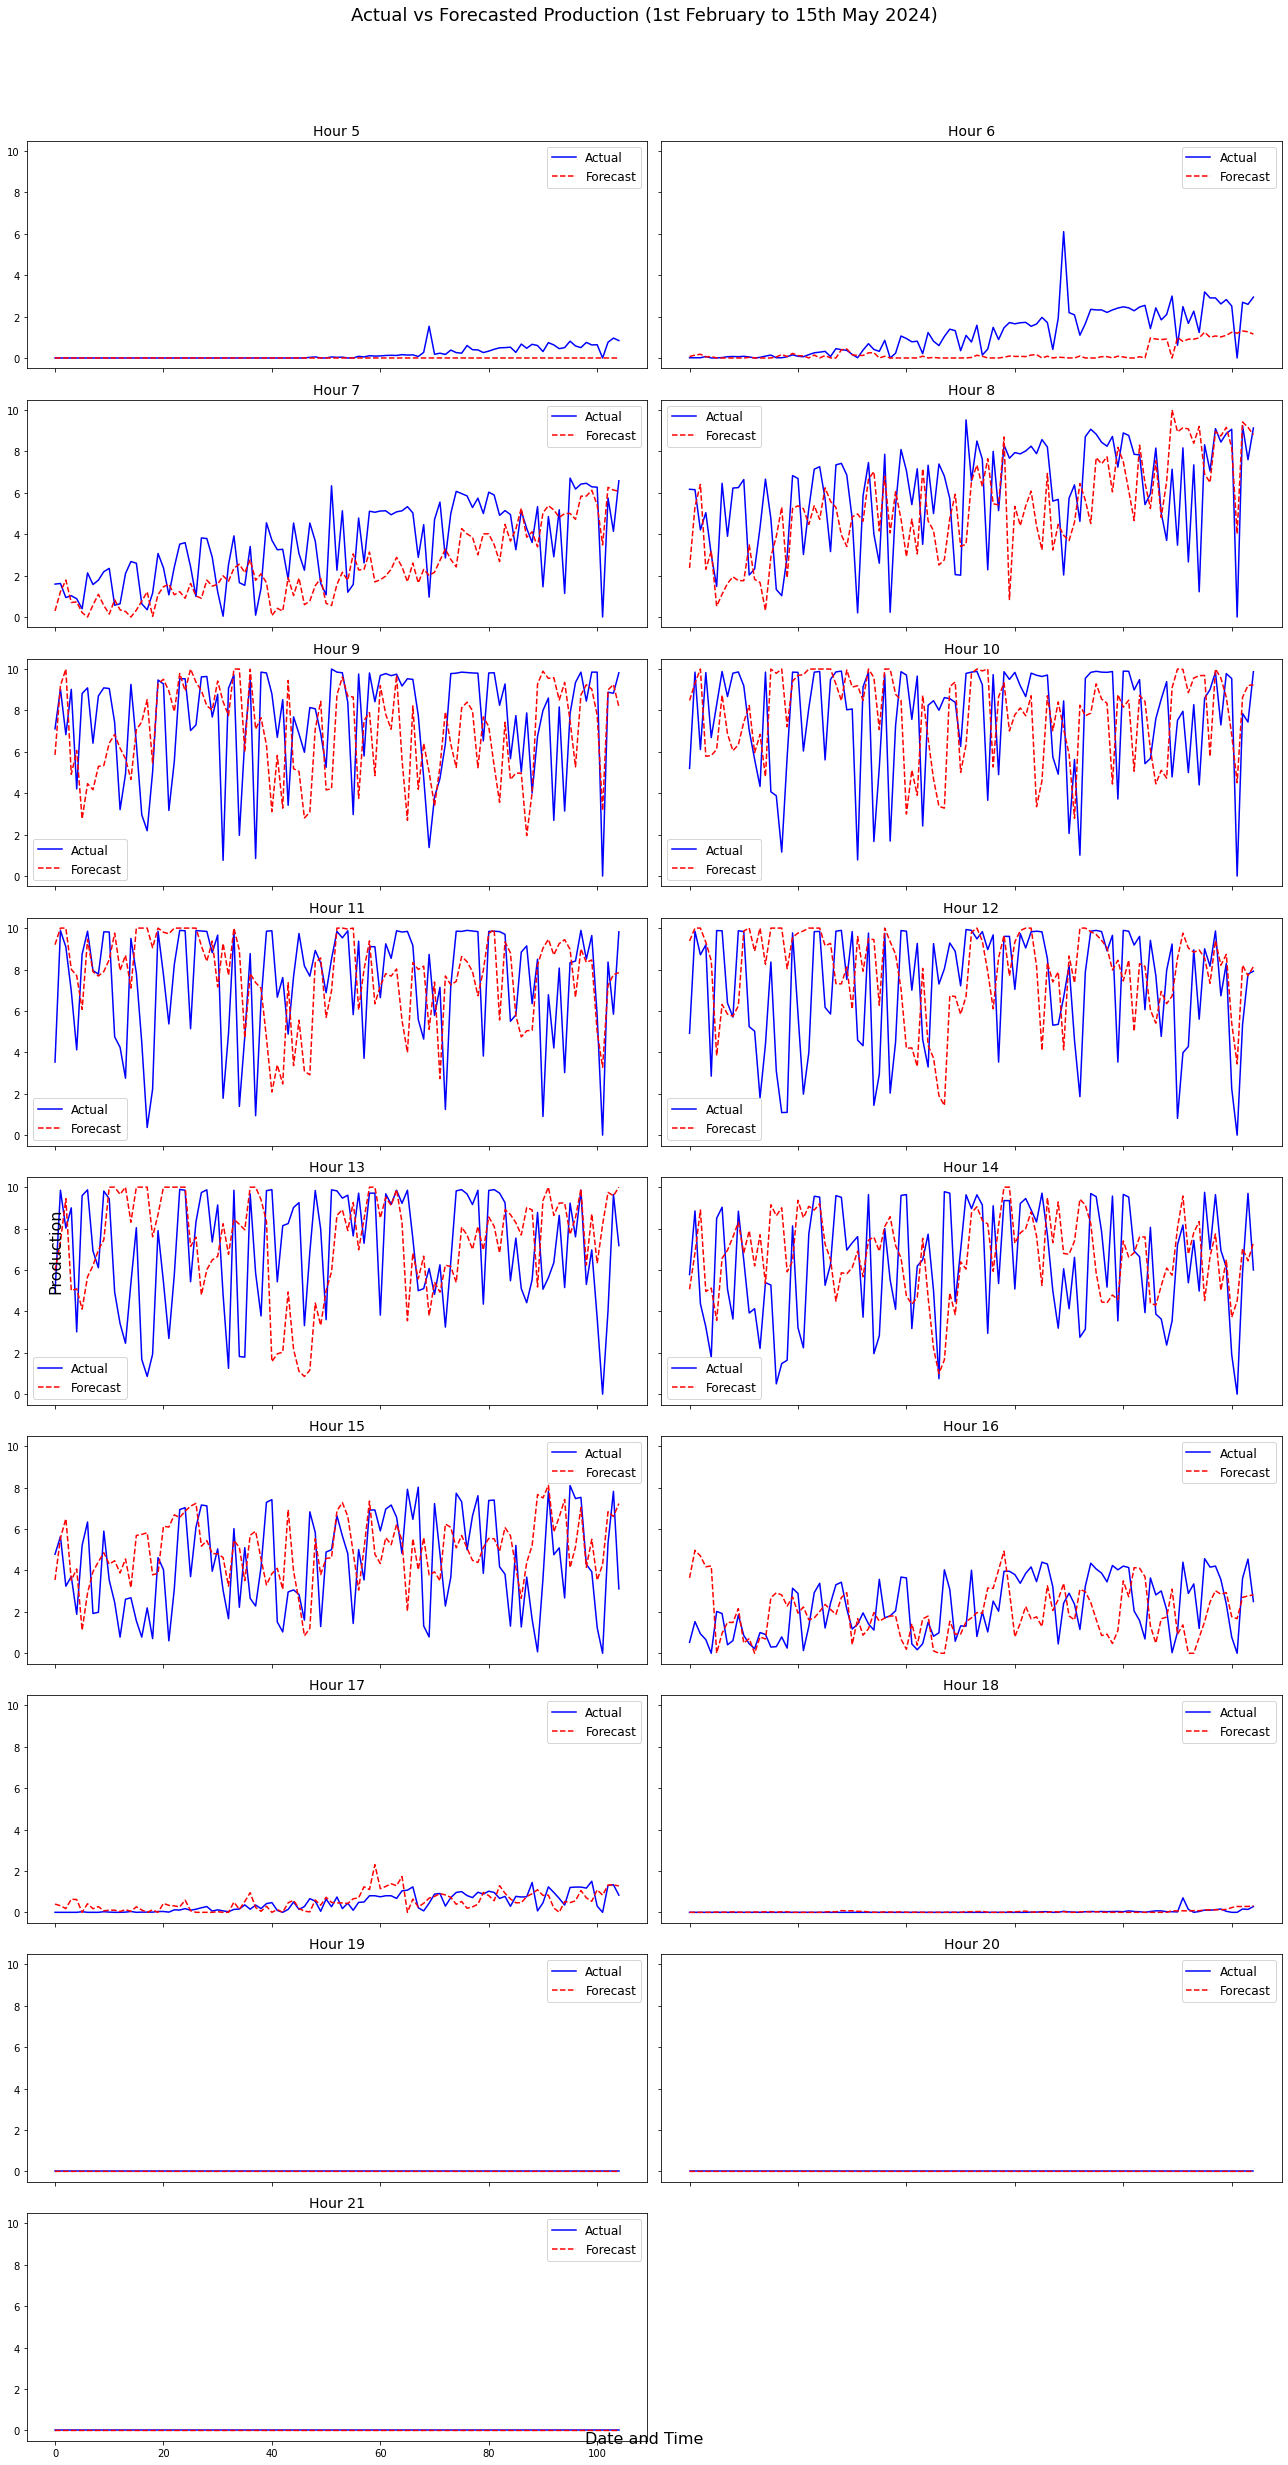

In [95]:
def get_hourly_forecasts(forecasts, hour):
    return np.array(forecasts[hour::24])

df_test = df_merged[(df_merged["date"] >= "2024-02-01") & (df_merged["date"] <= "2024-05-15")]
y_test = list(np.array(df_test.production))
final_forecast = flatten_forecast(forecast_list)

results = {"forecast": [], "actual": [], "hour": []}

# Plotting the results
fig, axes = plt.subplots(9, 2, figsize=(18, 36), sharex=True, sharey=True)
axes = axes.flatten()

for hour in range(24):
    forecast = get_hourly_forecasts(final_forecast, hour)
    real = get_hourly_forecasts(y_test, hour)

    if hour >= 5 and hour <= 21:
        ax = axes[hour - 5]
        ax.plot(np.arange(len(real)), real, label='Actual', color='blue')
        ax.plot(np.arange(len(forecast)),forecast, label='Forecast', color='red', linestyle='--')
        ax.set_title(f'Hour {hour}', fontsize=14)
        ax.legend(fontsize=12)
        
# Hide any unused subplots
for i in range(17, len(axes)):
    fig.delaxes(axes[i])

fig.text(0.5, 0.04, 'Date and Time', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Production', va='center', rotation='vertical', fontsize=16)

plt.suptitle('Actual vs Forecasted Production (1st February to 15th May 2024)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

In [96]:
weights = np.array(y_test) / np.array(y_test).sum()
wmape = mean_absolute_percentage_error(y_test, final_forecast, sample_weight=weights)
wmape

0.40681449461398167